<a href="https://colab.research.google.com/github/anosharahim/capstone/blob/master/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import Libraries

In [31]:
#for preprocessing
import pandas as pd
import os
import imageio
import numpy as np

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
%matplotlib inline

#for machine learning 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

In [32]:
#zipped_path = '/content/drive/MyDrive/Capstone/datasets/archive.zip'
#target_path = "/content/drive/MyDrive/Capstone/FER2013'
#unzip and extract files to gdrive
#!unzip zipped_path -d target_path

# Load and Preprocess Image Data

In [33]:
train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'

train_data = []
train_label = []
test_data = []
test_label = []

num_expressions = 6

#keep track of y labels 
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}


In [104]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_image_arrays(folder_path, label_dict):
  data = []
  label = []
  freq = {}

  for category in os.listdir(folder_path): 

    category_name = label_dict[category]
    category_path = folder_path + category + '/'
    freq[category] = 0

    for image in os.listdir(category_path):
      image_file = category_path + image 
      image_array = imageio.imread(image_file) #get image array from file 
      image_array.resize((32, 32))
      image_array = np.array(image_array) #convert to numpy array 
      #add image array and it's label to respective folders 
      data.append(image_array)
      label.append(category_name)
      freq[category] += 1

  data = np.array(data)
  label = np.array(label)

  data, label = unison_shuffled_copies(data, label)

  return data, label, freq


train_data, train_label, train_freq = get_image_arrays(train_path, emotion_dictionary)
test_data, test_label, test_freq = get_image_arrays(test_path, emotion_dictionary)

print('Training Data:',train_data.shape, 'Training Labels:',train_label.shape)
print('Test Data:',test_data.shape, 'Test Labels:', test_label.shape)
print('Training Set Class Sizes',train_freq)
print('Test Set Class Sizes',test_freq)

ValueError: ignored

In [ ]:
#oversampling minority classes to deal with class imbalance
#oversampler = RandomOverSampler(sampling_strategy='auto')
#train_over, train_label_over = oversampler.fit_resample(train_data, train_label)

In [52]:
import tensorflow.keras as K

In [68]:
#FER2013 is grayscale whereas ResNet50 takes in 3 channel RGB images. 
#duplicate values of 1 channel 

X_train = np.repeat(train_data[..., np.newaxis], 3, -1)
print(X_train.shape)  # (64, 224, 224, 3)
X_test = np.repeat(test_data[..., np.newaxis], 3, -1)
print(X_test.shape)  # (64, 224, 224, 3)

y_train, y_test = train_label, test_label


(28709, 48, 48, 3)
(7178, 48, 48, 3)


In [118]:
X_train = np.resize(X_train, (len(X_train), 48,48,3))
X_test = np.resize(X_train, (len(X_test), 48,48,3))

In [121]:
input_t = K.Input(shape=(48,48,3))
res50_model = K.applications.ResNet50(include_top=False, weights="imagenet",input_tensor=input_t)

In [122]:
for layer in res50_model.layers[:143]:
  layer.trainable =False

for i, layer in enumerate(res50_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_8 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [123]:
model = K.models.Sequential()
model.add(res50_model)
model.add(K.layers.Flatten())
model.add(K.layers.Dense(10, activation='softmax'))

In [124]:
check_point = K.callbacks.ModelCheckpoint(filepath="fer2013",
                                              monitor="val_acc",
                                              mode="max",
                                              save_best_only=True,
                                              )

model.compile(loss='categorical_crossentropy',
                  optimizer=K.optimizers.RMSprop(lr=2e-5),
                  metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1,
                        validation_data=(X_test, y_test),
                        callbacks=[check_point])
model.summary()
model.save("fer2013")

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


ValueError: ignored

# PCA: Principal Component Analysis

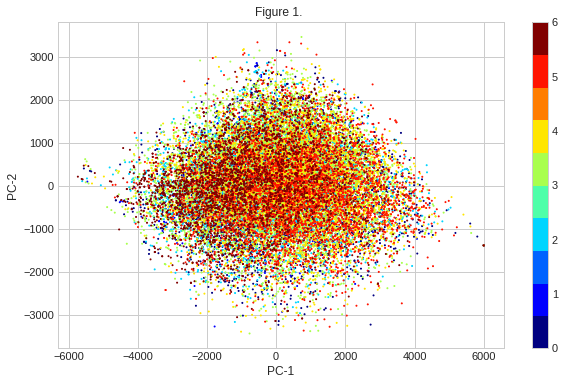

In [ ]:
#rescaling data between 0 and 1 
scaler = MinMaxScaler()
train_rescaled = scaler.fit_transform(train_data)

#Two-Component PCA
pca_ = PCA(n_components=2)
pca_ = pca_.fit_transform(train_data)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (10,6))
c_map = plt.cm.get_cmap('jet', 10)

plt.scatter(pca_[:, 0], pca_[:, 1], s = 1, cmap = c_map , c = train_label) 
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.title('Figure 1. ')
plt.show()



In [ ]:
#Three-Component PCA
pca_3d = PCA(n_components=3)
pca_3d = pca_3d.fit_transform(train_rescaled)

In [ ]:
#plot 3 components 

def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=2,
            color=train_label,      # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
    # tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_white'
    fig.show()

plt.ioff()
plot_3d(pca_3d[:, 0],pca_3d[:, 1],pca_3d[:, 2])

In [ ]:
#perform pca such that we have enough features to explain 95% of the variance in data 
_pca = PCA(n_components = 0.95) 
_pca.fit(train_rescaled)
reduced = _pca.transform(train_rescaled)
print(pca_.shape, reduced.shape) #253 features will explain 95% of the variance compared to the total 2034 features 

# TSNE: T-distributed Stochastic Neighbor Embedding (T-SNE)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



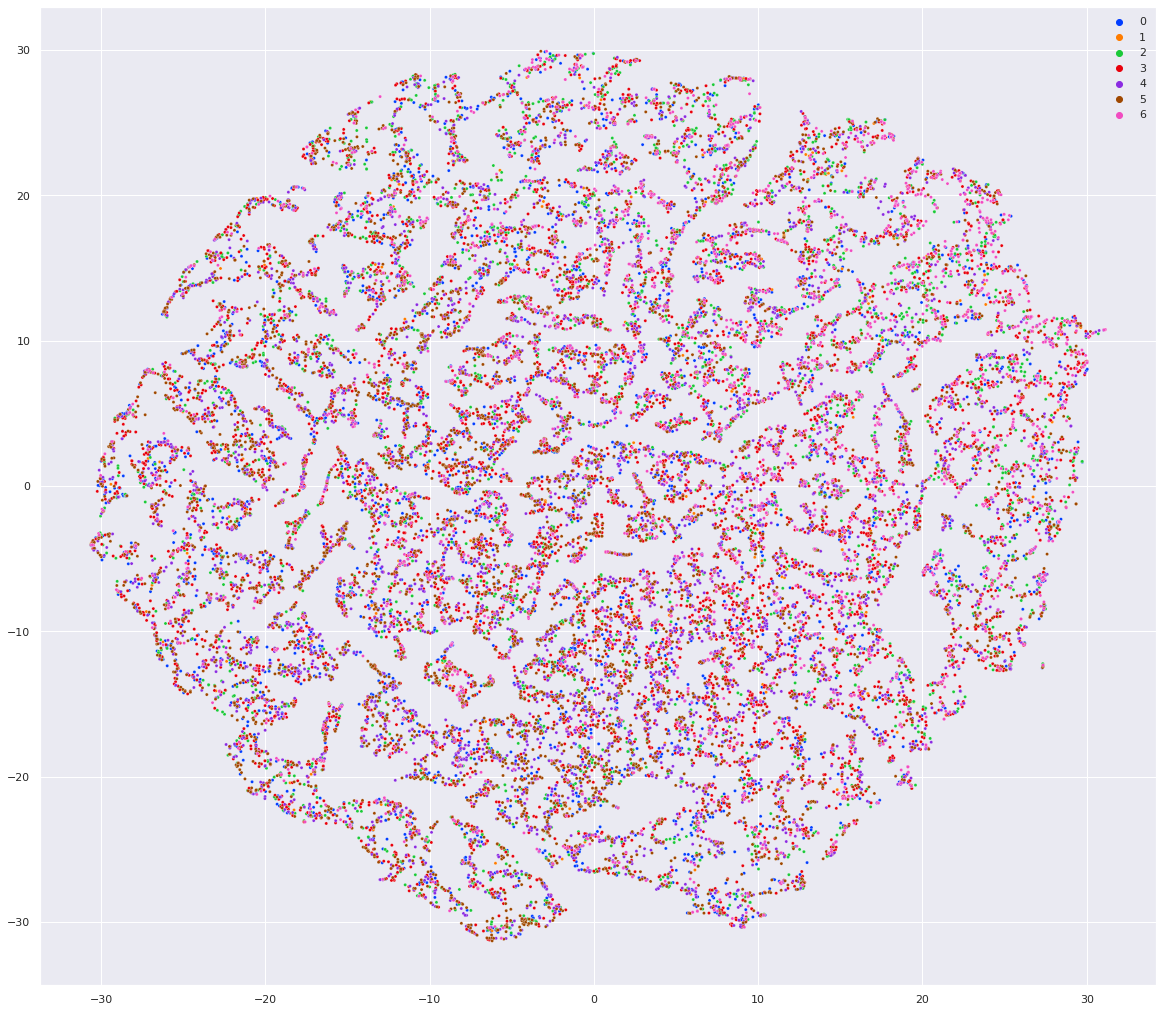

In [ ]:
tsne = TSNE(learning_rate=20)
TSNE_features = tsne.fit_transform(pca_3d)
a = TSNE_features[:,0]
b = TSNE_features[:,1]
sns.scatterplot(a,b,hue=train_label, legend='full',s=10, palette = 'bright')#, hue=y, legend='full')
sns.set(rc={'figure.figsize':(20,18)})

# UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction

Text(0.5, 1.0, 'UMAP projection of FER2013 dataset')

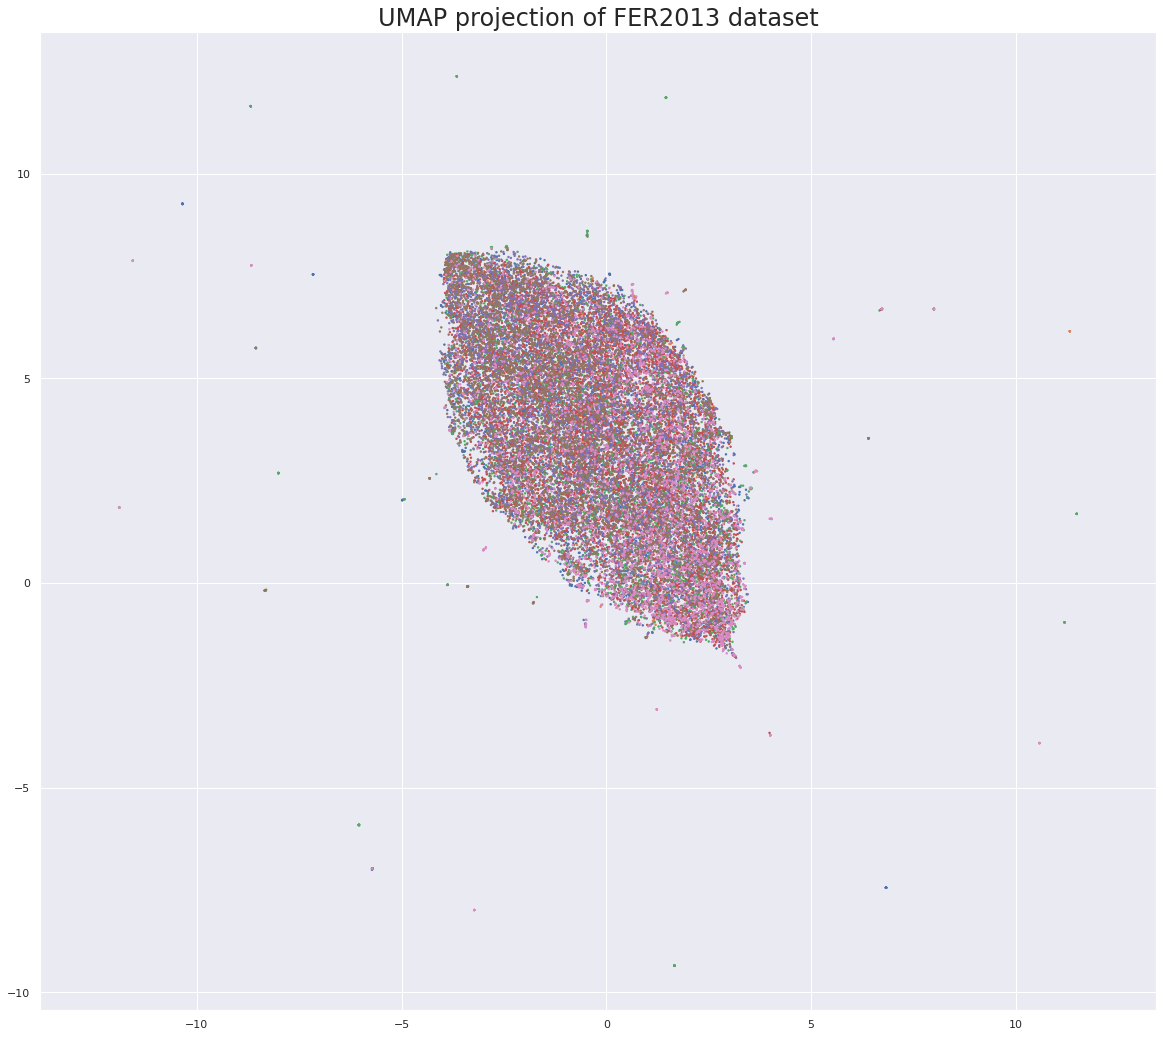

In [ ]:
import umap.umap_ as umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(train_rescaled)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in train_label], s= 2)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of FER2013 dataset', fontsize=24)